Summpip Paper Implementation

In [13]:
#make all necessary imports
import numpy as np
import nltk
import nltk.data
import os
import spacy
import tensorflow_hub as hub
import copy
import gensim.downloader as api
!pip install rouge
import spacy
import networkx as nx
from tqdm import tqdm
from rouge import Rouge
from sklearn.cluster import SpectralClustering
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import wordnet as wn
from ordered_set import OrderedSet
sentence_detector = nltk.data.load('tokenizers/punkt/english.pickle')
# use_tensorflow_embedding = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
glove_word_vectors = api.load("glove-wiki-gigaword-100")

[nltk_data] Downloading package wordnet to /home/siddhant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/siddhant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Extracting Sentences out of Data. (Preprocessing Step)

In [2]:
with open('./summarizer/DocsData.txt', 'r') as file:
    lines = file.readlines()

doc_separator_tag="story_separator_special_tag"
cnt = 0
line_sent_list = []
for line in lines:
    line = line.replace(doc_separator_tag, "")
    sent_list = sentence_detector.tokenize(line.strip())
    line_sent_list.append(sent_list)
    cnt += 1
    if cnt <= 5:
        print(sent_list)

print(len(line_sent_list))
docs = line_sent_list[:1]
print('Docs data for analysis')
print(docs)

["GOP Eyes Gains As Voters In 11 States Pick Governors Enlarge this image toggle caption Jim Cole / AP Jim Cole / AP Voters in 11 states will pick their governors tonight , and Republicans appear on track to increase their numbers by at least one , with the potential to extend their hold to more than two - thirds of the nation 's top state offices .", 'Eight of the gubernatorial seats up for grabs are now held by Democrats ; three are in Republican hands .', "Republicans currently hold 29 governorships , Democrats have 20 , and Rhode Island 's Gov.", 'Lincoln Chafee is an Independent .', "Polls and race analysts suggest that only three of tonight 's contests are considered competitive , all in states where incumbent Democratic governors are n't running again : Montana , New Hampshire and Washington .", 'While those state races remain too close to call , Republicans are expected to wrest the North Carolina governorship from Democratic control , and to easily win GOP - held seats in Utah

Graph Construction Step (Node will be a sentence)

In [3]:
#using spacynlp for POS(part of speech) tagging
spacynlp=spacy.load("en_core_web_sm")
verbs_to_escape = ["be", "is","am","are","was", "were", "being","been","do","did",
               "done","have","had","get","got","gotten"]

discourseMarkers=["for","so","because","since","therefore","consequently","additionally","furthermore","moreover",
         "but","however","although","despite","similarly","otherwise","whereas","while","unlike","thus",
        "instead","nevertheless","afterward","finally","subsequently","conversely","later","next","then",
         "likewise","compared","besides","further","as","also","equally","hence","accordingly","stil",
        "simultaneously"]

def convert_verb_to_nouns(sentence):
    tokens = spacynlp(sentence)
    nouns_arr = []
    for token in tokens:
        if token.pos_ == 'VERB' and token.text not in verbs_to_escape:
            tokenNouns = getNouns(token.text)
            # print('Here ', token.text, '-->> ', tokenNouns)
            nouns_arr.extend(tokenNouns)
            # print(nouns_arr)
    return nouns_arr

#Using getNouns to get lemmas(base word) of verbs
def getNouns(verb):
    baseform = wn.morphy(verb, wn.VERB)
    if baseform:
        lemmas = wn.lemmas(baseform, pos='v')
        noun_forms = []
        for lemma in lemmas:
            nouns = [form.name() for form in lemma.derivationally_related_forms()]
            noun_forms.extend(nouns)
        noun_forms = OrderedSet(noun_forms)
        return noun_forms
    else:
        return []
    
#find similar nouns based on cosine similarity from glove vectors dataset
def find_similar_nouns(nouns_list, word_vecs, thres=0.75):
    similar_nouns = []
    nouns = list(set(nouns_list))
    for noun in nouns:
        try:
            sim_word_list = word_vecs.most_similar(positive=[noun])
            sim_word_list = [tup[0] for tup in sim_word_list if tup[1]>thres]
            similar_nouns.extend(sim_word_list)
        except KeyError:
            pass
        similar_nouns.extend(nouns_list)
        return list(set(similar_nouns))
    
#Check for deverbal nouns in successive sentence
def check_deverbal_noun(similar_nouns, sent2):
    edge = False
    sent2words = spacynlp(sent2)
    if len(sent2words)>0:
        for token in sent2words:
            if token.pos_ == 'NOUN':
                if token.text in similar_nouns:
                    edge = True
                    break
    return edge

def check_discourse_markers(sent1, sent2):
    edge = False
    sent2words = spacynlp(sent2)
    if len(sent2words)>0:
        firstWord = sent2words[0].text
        if firstWord.lower() in discourseMarkers:
            edge = True
    return edge

def check_entity_continuation(sent1, sent2):
    edge = False
    words1 = spacynlp(sent1)
    words2 = spacynlp(sent2)
    if len(words1) > 0 and len(words2) > 0:
        entity1 = [(ent.text, ent.label_) for ent in words1.ents]
        entity2 = [(ent.text, ent.label_) for ent in words2.ents]
        for (text, label) in entity1:
            if (text, label) in entity2:
                edge=True
                break
    return edge
    

In [5]:
embed_size = 512 #for tensorflow embedding
adj_matrix = None
sentence_embeddings_matrix = None
use_tensorflow_embedding = hub.load('./universal-sentence-encoder_4')

#declares adjacency matrix and gives number of nodes and sentence embeddings(vector of size 512, per sentence)
def build_sentence_graph(document):
    num_nodes = len(document)
    # print(document)
    print('Number of nodes: ', num_nodes)
    sentence_embeddings_matrix = np.zeros([num_nodes, embed_size])
    adj_matrix = np.zeros([num_nodes, num_nodes])
    cnt = 0
    for sentence in document:
        sentence_embeddings_matrix[cnt] = use_tensorflow_embedding([sentence]).numpy()[0]
        cnt += 1
    return  num_nodes, adj_matrix,sentence_embeddings_matrix



#Fills Adjacency Matrix
def connect_sentence_nodes(document, num_nodes, adj_matrix, sentence_embeddings_matrix):
    for i in range(num_nodes):
        connect = False
        sentence1 = document[i]
        for j in range(i+1, num_nodes):
            sentence2 = document[j]
            if j-i == 1:
                nouns_list = convert_verb_to_nouns(sentence1)
                similar_nouns_list = find_similar_nouns(nouns_list, glove_word_vectors, 0.5)
                # print('Similar Nouns list: ', similar_nouns_list, ' for sentence ', sentence1)
                if similar_nouns_list is not None:
                    connect = check_deverbal_noun(similar_nouns_list, sentence2)
                if connect == False:
                    connect = check_discourse_markers(sentence1, sentence2)
            else:
                connect = check_entity_continuation(sentence1, sentence2)
            if connect == True:
                adj_matrix[i,j] = 1
                adj_matrix[j,i] = 1
    return adj_matrix

for doc in docs:
    num_nodes, adj_matrix, sentence_embeddings_matrix = build_sentence_graph(doc)
    adj_matrix = connect_sentence_nodes(doc, num_nodes, adj_matrix, sentence_embeddings_matrix)

Number of nodes:  19


2023-05-05 11:05:14.048643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


Final mat->> [[0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0.]
 [0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0

Perform Spectral Clustering on the Constructed Graph

["GOP Eyes Gains As Voters In 11 States Pick Governors Enlarge this image toggle caption Jim Cole / AP Jim Cole / AP Voters in 11 states will pick their governors tonight , and Republicans appear on track to increase their numbers by at least one , with the potential to extend their hold to more than two - thirds of the nation 's top state offices .", 'Eight of the gubernatorial seats up for grabs are now held by Democrats ; three are in Republican hands .', "Republicans currently hold 29 governorships , Democrats have 20 , and Rhode Island 's Gov.", 'Lincoln Chafee is an Independent .', "Polls and race analysts suggest that only three of tonight 's contests are considered competitive , all in states where incumbent Democratic governors are n't running again : Montana , New Hampshire and Washington .", 'While those state races remain too close to call , Republicans are expected to wrest the North Carolina governorship from Democratic control , and to easily win GOP - held seats in Utah

/home/siddhant/Documents/Acads/SEM2/SMAI/project/Summpip/.venv/lib/python3.10/site-packages/sklearn/cluster/_spectral.py:717: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


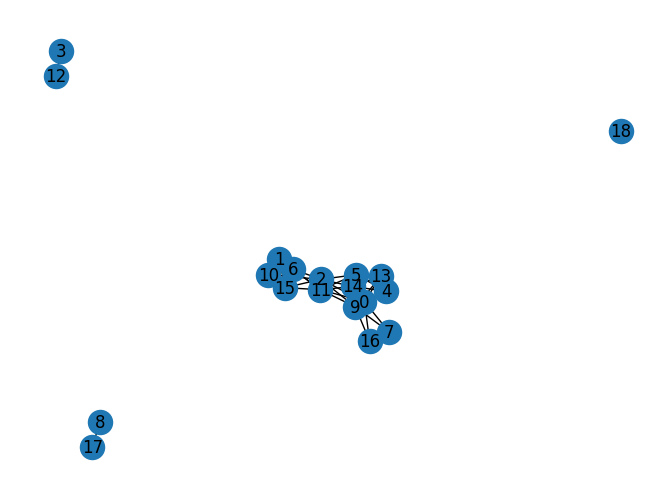

{0: 0.5, 1: 0.2222222222222222, 2: 0.4444444444444444, 3: 0.05555555555555555, 4: 0.2777777777777778, 5: 0.38888888888888884, 6: 0.2777777777777778, 7: 0.16666666666666666, 8: 0.05555555555555555, 9: 0.5, 10: 0.2222222222222222, 11: 0.4444444444444444, 12: 0.05555555555555555, 13: 0.2777777777777778, 14: 0.38888888888888884, 15: 0.2777777777777778, 16: 0.16666666666666666, 17: 0.05555555555555555, 18: 0.0}


In [17]:
import matplotlib.pyplot as plt
def spectralClustering(adj_mat, doc):
    clustering = SpectralClustering(n_clusters = 5, random_state = 88).fit(adj_mat)
    clusterIDs = clustering.labels_
    print(clusterIDs)
    # plt.title(f'Spectral clustering results ')
    # plt.scatter(adj_mat[:, 0], adj_mat[:, 1], s=50, c = clusterIDs)
    G = nx.from_numpy_array(adj_mat)
    nx.draw(G, with_labels=True)
    plt.show()
    degree_centrality = nx.degree_centrality(G)
    print(degree_centrality)

for doc in docs:
    print(doc)
    spectralClustering(adj_matrix, doc)